## Assignment 03
### Kheem Dharmani 22I-0081

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string as mystr
from nltk.corpus import stopwords
nltk.download('stopwords')
RemoveWords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KHEEM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Softmax Activation Function 

In [2]:
def softmax(x):
	e_x = np.exp(x - np.max(x))
	return e_x / e_x.sum()

# Corpus Preprocessing

In [3]:
def Clean_Corpus(corpus):
    #blank corpus set
    Corpus_set = []

    # split each sentences
    sentences = corpus.split(".") 
    #loop through each word in each sentence
    for eachWord in range(len(sentences)):

      #remove spaces
      sentences[eachWord] = sentences[eachWord].strip () 
      Eachsentence = sentences[eachWord].split() #split sentence by blank spaces          
      myWords = [word.strip(mystr.punctuation) for word in Eachsentence if word.lower() not in RemoveWords] #remove puntuations and stopword
      myWords = [word.lower() for word in myWords if word.lower() !=""] #remove blanks and make lower
     
      Corpus_set.append(myWords)# append to array of corpus set

    return Corpus_set

# One Hot Encoding

In [4]:
#This function create One hot encoding for Input words and the context words
def OneHotEncoding(sentences,model):
    mydata = {}
    for sentence in sentences:
        for word in sentence:
            if word not in mydata:
                mydata[word] = 1
            else:
                mydata[word] += 1
    V = len(mydata)

    mydata = sorted(list(mydata.keys()))
    
    for i in range(len(mydata)):
        model.vocab[mydata[i]] = i
      
    #for i in range(len(words)):
    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(V)]
            center_word[model.vocab[sentence[i]]] = 1
            context = [0 for x in range(V)]
             
            for j in range(i-model.Context_Window,i+model.Context_Window):
                if i!=j and j>=0 and j<len(sentence):
                    context[model.vocab[sentence[j]]] += 1
                  
            model.X_train.append(center_word)
            model.y_train.append(context)

    #Initialize the weights of NN
    model.InitializeWeights(V,mydata)
  
    return model.X_train,model.y_train 

# Skip Gram Model 

In [31]:
class SkipGramModel(object):
    def __init__(self):
        self.Neuron = 50
        self.lr = 0.005    # learning rate
        self.Context_Window = 2 # windows size is 2

        self.X_train = []
        self.y_train = []
        

        self.words = []
        self.word_index = {}
        self.vocab = {}
  
    def InitializeWeights(self,V,data):
        self.V = V
        self.W = np.random.uniform(-0.8, 0.8, (self.V, self.Neuron))
        self.W1 = np.random.uniform(-0.8, 0.8, (self.Neuron, self.V))
          
        self.words = data
        for i in range(len(data)):
            self.word_index[data[i]] = i
            
    def train(self,mytol,maxepochs=20000):
        #initialize loss
        self.loss =0
        self.loss1 = 1 #random number 1
        itr=1
        
        while abs(self.loss1 - self.loss)>= mytol and itr <= maxepochs:
            self.loss1 = self.loss
            self.loss = 0
            for j in range(len(self.X_train)):

                # implementing feedforward 
                self.h = np.dot(self.W.T,self.X_train[j]).reshape(self.Neuron,1)
                self.u = np.dot(self.W1.T,self.h)
                self.y = softmax(self.u)
                
                # implementation of back propogration
                error = self.y - np.asarray(self.y_train[j]).reshape(self.V,1)
                dLdW1 = np.dot(self.h,error.T)
                X = np.array(self.X_train[j]).reshape(self.V,1)
                dLdW = np.dot(X, np.dot(self.W1,error).T)

                self.W1 = self.W1 - self.lr*dLdW1
                self.W = self.W - self.lr*dLdW

                #loss Function
                C = 0
                for m in range(self.V):
                    if(self.y_train[j][m]):
                        self.loss += -1*self.u[m][0]
                        C += 1
                self.loss += C*np.log(np.sum(np.exp(self.u)))
            #Print loss
            print("epoch ",itr, " loss = ",self.loss)
            #update adaptive alpha
            self.lr *= 1/( (1+self.lr*itr) )
            itr=itr+1
     # function for predication         
    def predict(self,word,number_of_predictions):
        if word in self.words:
            index = self.word_index[word]
            X = [0 for i in range(self.V)]
            X[index] = 1


            #prediction = self.feed_forward(X)
            self.h = np.dot(self.W.T,X).reshape(self.Neuron,1)
            self.u = np.dot(self.W1.T,self.h)
            self.y = softmax(self.u)
            prediction=self.y
            print(prediction)

            output = {}
            for i in range(self.V):
                output[prediction[i][0]] = i
              
            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.words[output[k]])
                if(len(top_context_words)>=number_of_predictions):
                    break
      
            return top_context_words
        else:
            print("Word not found")

# Embeddings 

In [32]:
def Get_Embeding(myword,SkipGram):
  WeightMatrix = SkipGram.W1.T
  return WeightMatrix[SkipGram.word_index[myword]]

# Cosine Similarity

In [33]:
def cosine_similarity(word1, word2,SkipGram):
  temp = SkipGram.W1.T
  temp.shape
  a=Get_Embeding(word1,SkipGram)
  b=Get_Embeding(word2,SkipGram)
  dot_product = np.dot(a, b)
  norm_a = np.linalg.norm(a)
  norm_b = np.linalg.norm(b)
  return np.dot(a, b)/np.sqrt(np.dot(a, a)*np.dot(b, b))
  return dot_product / (norm_a * norm_b)

# Importing data

In [34]:
filename = 'training_text.txt'
data = np.loadtxt(filename, delimiter='/',  dtype=str)
data
corpus = ""
for i in range(len(data)):
  corpus= corpus  + data[i]
print(corpus)

Today we will be learning about the fundamentals of data science and statistics. Data Science and statistics are hot and growing fields withalternative names of machine learning, artificial intelligence, big data, etc. I'm really excited to talk to you about data science andstatistics because data science and statistics have long been passions of mine. I didn't use to be very good at data science and statistics butafter studying data science and statistics for a long time, I got better and better at it until I became a data science and statisticsexpert. I'm really excited to talk to you about data science and statistics, thanks for listening to me talk about data science andstatistics.


In [35]:
corpus_Set = Clean_Corpus(corpus)
print(" number of sentences :", len(corpus_Set))

 number of sentences : 6


# Creating Skipgram model and vocabulary set

In [36]:
model = SkipGramModel()
Onehotencoding =OneHotEncoding(corpus_Set,model)
print("Number of words in vocabularly:", len(model.vocab))
print("Vocabulary Set : ", model.vocab)

Number of words in vocabularly: 35
Vocabulary Set :  {'andstatistics': 0, 'artificial': 1, 'became': 2, 'better': 3, 'big': 4, 'butafter': 5, 'data': 6, 'etc': 7, 'excited': 8, 'fields': 9, 'fundamentals': 10, 'good': 11, 'got': 12, 'growing': 13, 'hot': 14, "i'm": 15, 'intelligence': 16, 'learning': 17, 'listening': 18, 'long': 19, 'machine': 20, 'mine': 21, 'names': 22, 'passions': 23, 'really': 24, 'science': 25, 'statistics': 26, 'statisticsexpert': 27, 'studying': 28, 'talk': 29, 'thanks': 30, 'time': 31, 'today': 32, 'use': 33, 'withalternative': 34}


# Training model 

In [37]:
maxepochs = 1000
le= 1e-2
model.train(le,maxepochs)

epoch  1  loss =  732.452025891224
epoch  2  loss =  690.8853698750794
epoch  3  loss =  659.7602649038286
epoch  4  loss =  636.5901169981258
epoch  5  loss =  618.4666360513241
epoch  6  loss =  603.5416653445506
epoch  7  loss =  590.9186884358492
epoch  8  loss =  580.1305062828443
epoch  9  loss =  570.8593772796715
epoch  10  loss =  562.8733520231958
epoch  11  loss =  556.0128536744809
epoch  12  loss =  550.1650083608989
epoch  13  loss =  545.2353461804807
epoch  14  loss =  541.1310756054052
epoch  15  loss =  537.7572633277274
epoch  16  loss =  535.0202819369509
epoch  17  loss =  532.8327339234256
epoch  18  loss =  531.1167627213486
epoch  19  loss =  529.805154141527
epoch  20  loss =  528.8408423115667
epoch  21  loss =  528.175633772145
epoch  22  loss =  527.7687358713855
epoch  23  loss =  527.5853979079586
epoch  24  loss =  527.595779156858
epoch  25  loss =  527.7740539487446
epoch  26  loss =  528.097720683677
epoch  27  loss =  528.5470707842501
epoch  28  loss

epoch  232  loss =  616.2073971864268
epoch  233  loss =  616.319428514813
epoch  234  loss =  616.4305892445647
epoch  235  loss =  616.5408893949935
epoch  236  loss =  616.6503388338323
epoch  237  loss =  616.7589472800555
epoch  238  loss =  616.8667243066378
epoch  239  loss =  616.973679343253
epoch  240  loss =  617.0798216789166
epoch  241  loss =  617.1851604645633
epoch  242  loss =  617.2897047155781
epoch  243  loss =  617.393463314266
epoch  244  loss =  617.4964450122734
epoch  245  loss =  617.598658432953
epoch  246  loss =  617.7001120736812
epoch  247  loss =  617.8008143081269
epoch  248  loss =  617.9007733884671
epoch  249  loss =  617.9999974475621
epoch  250  loss =  618.0984945010819
epoch  251  loss =  618.1962724495842
epoch  252  loss =  618.293339080556
epoch  253  loss =  618.389702070407
epoch  254  loss =  618.4853689864244
epoch  255  loss =  618.5803472886827
epoch  256  loss =  618.674644331923
epoch  257  loss =  618.768267367381
epoch  258  loss =  

epoch  452  loss =  629.4759282253892
epoch  453  loss =  629.5081464091369
epoch  454  loss =  629.5402288134745
epoch  455  loss =  629.5721762932385
epoch  456  loss =  629.6039896961177
epoch  457  loss =  629.6356698627295
epoch  458  loss =  629.667217626695
epoch  459  loss =  629.6986338147075
epoch  460  loss =  629.7299192466095
epoch  461  loss =  629.7610747354579
epoch  462  loss =  629.7921010875981
epoch  463  loss =  629.8229991027299
epoch  464  loss =  629.8537695739783
epoch  465  loss =  629.8844132879593
epoch  466  loss =  629.9149310248457
epoch  467  loss =  629.9453235584353
epoch  468  loss =  629.9755916562141
epoch  469  loss =  630.0057360794171
epoch  470  loss =  630.0357575831009
epoch  471  loss =  630.0656569161948
epoch  472  loss =  630.0954348215718
epoch  473  loss =  630.1250920361038
epoch  474  loss =  630.1546292907253
epoch  475  loss =  630.1840473104912
epoch  476  loss =  630.2133468146367
epoch  477  loss =  630.2425285166341
epoch  478  l

epoch  677  loss =  634.3962310994799
epoch  678  loss =  634.4110184229593
epoch  679  loss =  634.4257634177333
epoch  680  loss =  634.4404662651405
epoch  681  loss =  634.4551271454824
epoch  682  loss =  634.469746238037
epoch  683  loss =  634.4843237210637
epoch  684  loss =  634.4988597718085
epoch  685  loss =  634.5133545665144
epoch  686  loss =  634.5278082804267
epoch  687  loss =  634.5422210878007
epoch  688  loss =  634.5565931619074
epoch  689  loss =  634.5709246750437
epoch  690  loss =  634.5852157985341
epoch  691  loss =  634.5994667027426
epoch  692  loss =  634.6136775570745
epoch  693  loss =  634.6278485299897
epoch  694  loss =  634.641979789003
epoch  695  loss =  634.6560715006926
epoch  696  loss =  634.6701238307095
epoch  697  loss =  634.6841369437792
epoch  698  loss =  634.6981110037121
epoch  699  loss =  634.7120461734081
epoch  700  loss =  634.7259426148626
epoch  701  loss =  634.7398004891728
epoch  702  loss =  634.7536199565457
epoch  703  lo

# Predict Context

In [38]:
print(model.predict("data",4))

[[2.02058179e-03]
 [8.07644611e-09]
 [2.16033701e-04]
 [1.12387664e-04]
 [2.21282077e-04]
 [1.04265199e-05]
 [5.25232808e-06]
 [7.43464538e-06]
 [4.87837745e-04]
 [5.47097886e-09]
 [4.06171368e-06]
 [1.76692313e-04]
 [4.63276901e-07]
 [3.06958036e-08]
 [1.70379015e-06]
 [4.67508186e-07]
 [7.66749195e-04]
 [4.92627926e-04]
 [1.18775700e-07]
 [2.57077211e-09]
 [2.74425201e-09]
 [1.23717245e-09]
 [7.95389196e-09]
 [4.15927710e-09]
 [7.53426695e-07]
 [8.42469981e-01]
 [8.51189306e-10]
 [3.53082815e-08]
 [3.62949061e-06]
 [1.52964410e-01]
 [2.78838333e-07]
 [1.45192148e-09]
 [2.07969270e-07]
 [3.56947599e-05]
 [8.23153909e-07]]
['science', 'talk', 'andstatistics', 'intelligence']


In [25]:
print(model.predict("science",4))

['data', 'statistics', 'andstatistics', 'talk']


In [26]:
print(model.predict("learning",2))

['fundamentals', 'today']


In [27]:
print(model.predict("artificial",4))

['intelligence', 'machine', 'learning', 'statistics']


In [28]:
print(model.predict("big",4))

['data', 'intelligence', 'machine', 'passions']


# Cosine Similarity Matrix

In [70]:
WordsArray =np.array(["data","science","artificial","intelligence","statistics","machine","learning","big", "growing"])

In [52]:
Embedingarray= []
Values=np.zeros((9,9)) # size match to wordsArray
for i in range(len(WordsArray)):
    for j in range(len(WordsArray)):
        Values[i][j]=cosine_similarity(WordsArray[i], WordsArray[j],model)
        #print(WordsArray[i], WordsArray[j],Values[i][j])
    Embedingarray.append(Get_Embeding(WordsArray[i],model))
cos_mtx = pd.DataFrame(data=Values,columns=WordsArray,index=WordsArray)
cos_mtx

,data,science,artificial,intelligence,statistics,machine,learning,big,growing
data,1.000000,0.444702,-0.114160,0.227669,0.470095,0.004000,0.049742,0.079804,-0.195161
science,0.444702,1.000000,-0.119084,0.266613,0.046760,0.101747,0.113104,-0.033203,-0.106470
artificial,-0.114160,-0.119084,1.000000,-0.012224,-0.096268,-0.006003,-0.147256,0.086092,-0.120642
intelligence,0.227669,0.266613,-0.012224,1.000000,0.257684,0.101304,0.111921,-0.060227,-0.095814
statistics,0.470095,0.046760,-0.096268,0.257684,1.000000,0.156809,0.064597,-0.233714,-0.166361
machine,0.004000,0.101747,-0.006003,0.101304,0.156809,1.000000,-0.131546,-0.124875,0.266298
learning,0.049742,0.113104,-0.147256,0.111921,0.064597,-0.131546,1.000000,0.095144,-0.232431
big,0.079804,-0.033203,0.086092,-0.060227,-0.233714,-0.124875,0.095144,1.000000,-0.299149
growing,-0.195161,-0.106470,-0.120642,-0.095814,-0.166361,0.266298,-0.232431,-0.299149,1.000000


<AxesSubplot: >

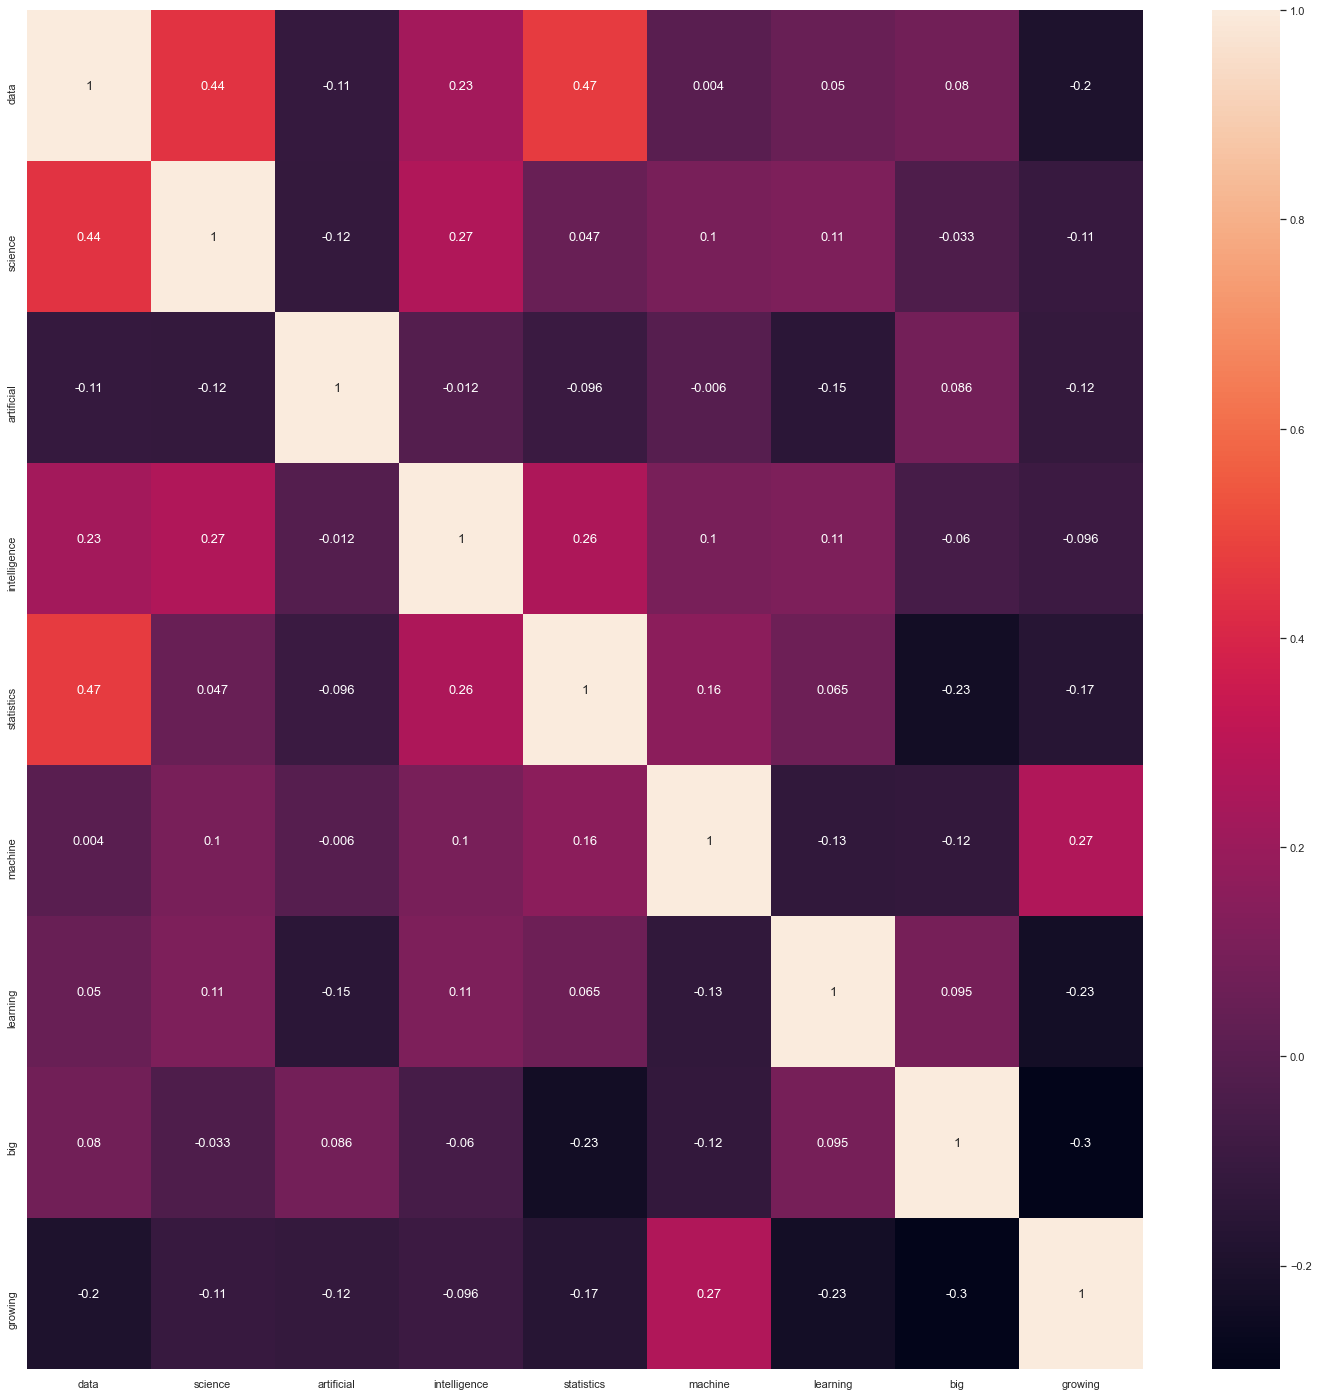

In [54]:
sns.set(rc={"figure.figsize":(25, 25)}) 
sns.heatmap(cos_mtx, annot=True, annot_kws={"size":13})